In [17]:
import re
import string
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""

    def remove_articles(text):
        return re.sub(r"\b(a|an|the)\b", " ", text)

    def white_space_fix(text):
        return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

def f1_score(prediction, ground_truth):
    common = Counter(prediction) & Counter(ground_truth)
    num_same = sum(common.values())
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(prediction)
    recall = 1.0 * num_same / len(ground_truth)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

def qa_f1_score(prediction, ground_truth):
    normalized_prediction = normalize_answer(prediction)
    normalized_ground_truth = normalize_answer(ground_truth)

    prediction_tokens = normalized_prediction.split()
    ground_truth_tokens = normalized_ground_truth.split()
    return f1_score(prediction_tokens, ground_truth_tokens)

In [31]:
percentages = [25, 50, 75]
dataset_name_list = ['hotpotqa', 'narrativeqa', 'triviaqa', 'multifieldqa']
all_bart_metric = {
    'hotpotqa': None, 
    'narrativeqa': None, 
    'triviaqa': None, 
    'multifieldqa': None
}

for dataset_name in dataset_name_list:
    summ_metrics_df = pd.DataFrame(columns=['Compression (%)', 'F1', 'Latency (s)', 'memory_usage', 'Peak Memory (MB)'])
    for i in percentages:
        df1 = pd.read_csv(f"summarization_model_experiment/{dataset_name}/summarize_{dataset_name}_{i}.csv")
        df2 = pd.read_json(f"summarization_model_experiment/metrics_jsons/{dataset_name}_metrics_{i}.json")
        df = df1.merge(df2, how='inner', on='_id')
        df = df[df['responses'].notna()]
        df['answers'] = df['answers'].apply(lambda x: x[2:-2])
        f1_scores = []
        for idx, row in df.iterrows():
            f1_scores.append(qa_f1_score(row['responses'], row['answers']))
        df['f1_scores'] = f1_scores
        metric = [i]
        metric.extend(list(df[['f1_scores', 'latencies', 'memory_usages', 'peak_memory_usages']].mean()))
        summ_metrics_df.loc[len(summ_metrics_df)] = metric
    all_bart_metric[dataset_name] = summ_metrics_df

print(all_bart_metric)

{'hotpotqa':    Compression (%)        F1  Latency (s)  memory_usage  Peak Memory (MB)
0             25.0  0.386414     0.747483  11944.816895      12641.208311
1             50.0  0.295676     1.349584  11944.816895      13283.069219
2             75.0  0.271321     2.123703  11944.816895      13924.156240, 'narrativeqa':    Compression (%)        F1  Latency (s)  memory_usage  Peak Memory (MB)
0             25.0  0.137270     1.427125  11944.816895      13164.961357
1             50.0  0.172320     2.920950  11944.816895      14339.941094
2             75.0  0.065592     3.857178  11944.816895      15049.612725, 'triviaqa':    Compression (%)        F1  Latency (s)  memory_usage  Peak Memory (MB)
0             25.0  0.202153     0.698029  11944.816895      12629.226436
1             50.0  0.208466     1.173720  11944.816895      13134.952549
2             75.0  0.212184     1.741954  11944.816895      13641.088223, 'multifieldqa':    Compression (%)        F1  Latency (s)  memory_usa

In [54]:
# Update values here
llmlingua_data = {
    'hotpotqa': {
        "Compression (%)": [25, 50, 75],
        "F1": [0, 0, 0],
        "Latency (s)": [0, 0, 0],
        "Peak Memory (MB)": [0, 0, 0]
    }, 
    'narrativeqa': {
        "Compression (%)": [25, 50, 75],
        "F1": [0, 0, 0],
        "Latency (s)": [0, 0, 0],
        "Peak Memory (MB)": [0, 0, 0]
    }, 
    'triviaqa': {
        "Compression (%)": [25, 50, 75],
        "F1": [0, 0, 0],
        "Latency (s)": [0, 0, 0],
        "Peak Memory (MB)": [0, 0, 0]
    }, 
    'multifieldqa': {
        "Compression (%)": [25, 50, 75],
        "F1": [0, 0, 0],
        "Latency (s)": [0, 0, 0],
        "Peak Memory (MB)": [0, 0, 0]
    }
}

# Update values here
random_token_pruning_data = {
    'hotpotqa': {
        "Compression (%)": [25, 50, 75],
        "F1": [0.1, 0.07, 0.14],
        "Latency (s)": [1.21, 1.5, 2.16],
        "Peak Memory (MB)": [12586.63, 13224.21, 13865.97]
    }, 
    'narrativeqa': {
        "Compression (%)": [25, 50, 75],
        "F1": [0.1, 0.17, 0.21],
        "Latency (s)": [1.37, 2.64, 2.89],
        "Peak Memory (MB)": [24918.94, 26116.02, 27624.16]
    }, 
    'triviaqa': {
        "Compression (%)": [25, 50, 75],
        "F1": [0.38, 0.4, 0.39],
        "Latency (s)": [0.73, 1.26, 1.84],
        "Peak Memory (MB)": [12621.81, 13158.16, 13698.63]
    }, 
    'multifieldqa': {
        "Compression (%)": [25, 50, 75],
        "F1": [0.17, 0.25, 0.36],
        "Latency (s)": [1.41, 1.72, 1.5],
        "Peak Memory (MB)": [12275.20, 12703.44, 13083.73]
    }
}

no_pruning_data = {
    "Compression (%)": "Full Context",
    "F1": 0.44,
    "Latency (s)": 2.16,
    "Peak Memory (MB)": 13264.43
}

# Create DataFrames
llmlingua_metrics = {}
for i in llmlingua_data.keys():
    llmlingua_metrics[i] = pd.DataFrame(llmlingua_data[i])

random_token_pruning_metrics = {}
for i in random_token_pruning_data.keys():
    random_token_pruning_metrics[i] = pd.DataFrame(random_token_pruning_data[i])

# Display DataFrames
print("LLM Lingua DataFrame:")
print(llmlingua_metrics, "\n")

print("Random Token Pruning DataFrame:")
print(random_token_pruning_metrics, "\n")

print("No Pruning Data:")
print(no_pruning_data)

LLM Lingua DataFrame:
{'hotpotqa':    Compression (%)  F1  Latency (s)  Peak Memory (MB)
0               25   0            0                 0
1               50   0            0                 0
2               75   0            0                 0, 'narrativeqa':    Compression (%)  F1  Latency (s)  Peak Memory (MB)
0               25   0            0                 0
1               50   0            0                 0
2               75   0            0                 0, 'triviaqa':    Compression (%)  F1  Latency (s)  Peak Memory (MB)
0               25   0            0                 0
1               50   0            0                 0
2               75   0            0                 0, 'multifieldqa':    Compression (%)  F1  Latency (s)  Peak Memory (MB)
0               25   0            0                 0
1               50   0            0                 0
2               75   0            0                 0} 

Random Token Pruning DataFrame:
{'hotpotqa':    Comp

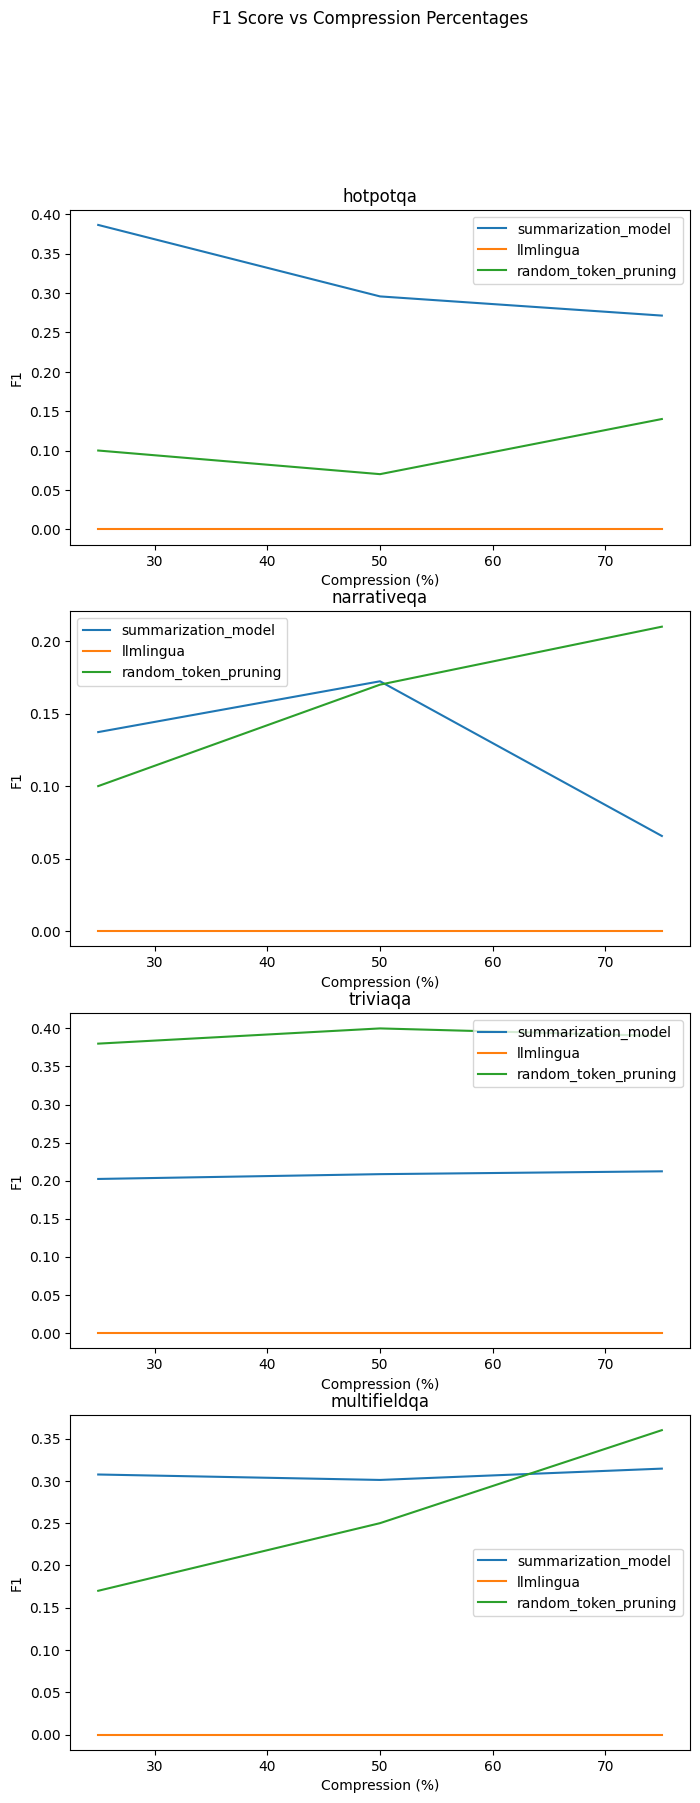

In [57]:
fig, axes = plt.subplots(4, figsize=(8, 20))
fig.suptitle('F1 Score vs Compression Percentages')

for i, dataset_name in enumerate(dataset_name_list):
    axes[i].plot(all_bart_metric[dataset_name]['Compression (%)'], all_bart_metric[dataset_name]['F1'], label='summarization_model')
    axes[i].plot(llmlingua_metrics[dataset_name]['Compression (%)'], llmlingua_metrics[dataset_name]['F1'], label='llmlingua')
    axes[i].plot(random_token_pruning_metrics[dataset_name]['Compression (%)'], random_token_pruning_metrics[dataset_name]['F1'], label='random_token_pruning')
    axes[i].set_title(dataset_name)
    axes[i].legend()
    axes[i].set_xlabel('Compression (%)')
    axes[i].set_ylabel('F1')

plt.show()

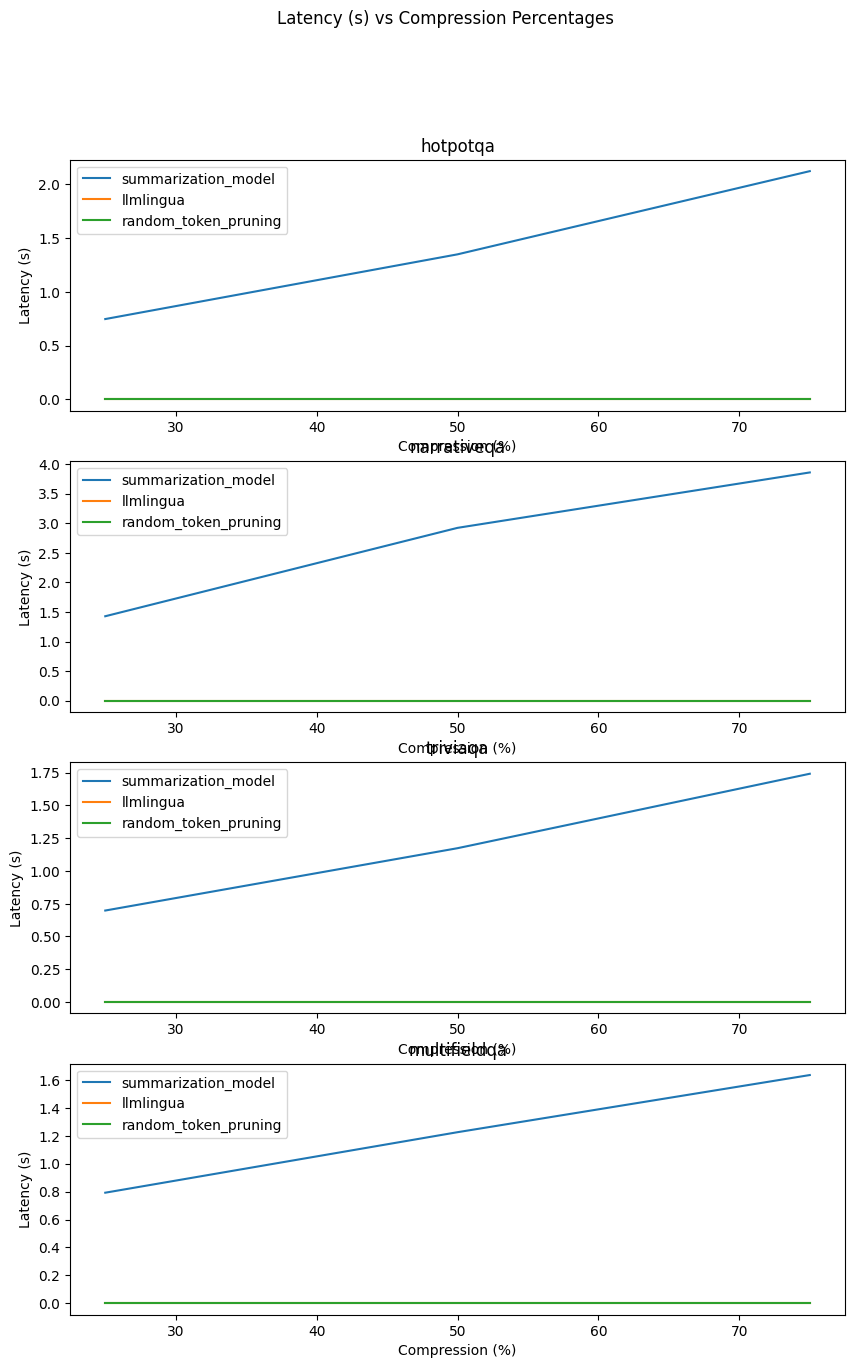

In [52]:
fig, axes = plt.subplots(4, figsize=(10, 15))
fig.suptitle('Latency (s) vs Compression Percentages')

for i, dataset_name in enumerate(dataset_name_list):
    axes[i].plot(all_bart_metric[dataset_name]['Compression (%)'], all_bart_metric[dataset_name]['Latency (s)'], label='summarization_model')
    axes[i].plot(llmlingua_metrics[dataset_name]['Compression (%)'], llmlingua_metrics[dataset_name]['Latency (s)'], label='llmlingua')
    axes[i].plot(random_token_pruning_metrics[dataset_name]['Compression (%)'], random_token_pruning_metrics[dataset_name]['Latency (s)'], label='random_token_pruning')
    axes[i].set_title(dataset_name)
    axes[i].legend()
    axes[i].set_xlabel('Compression (%)')
    axes[i].set_ylabel('Latency (s)')

plt.show()

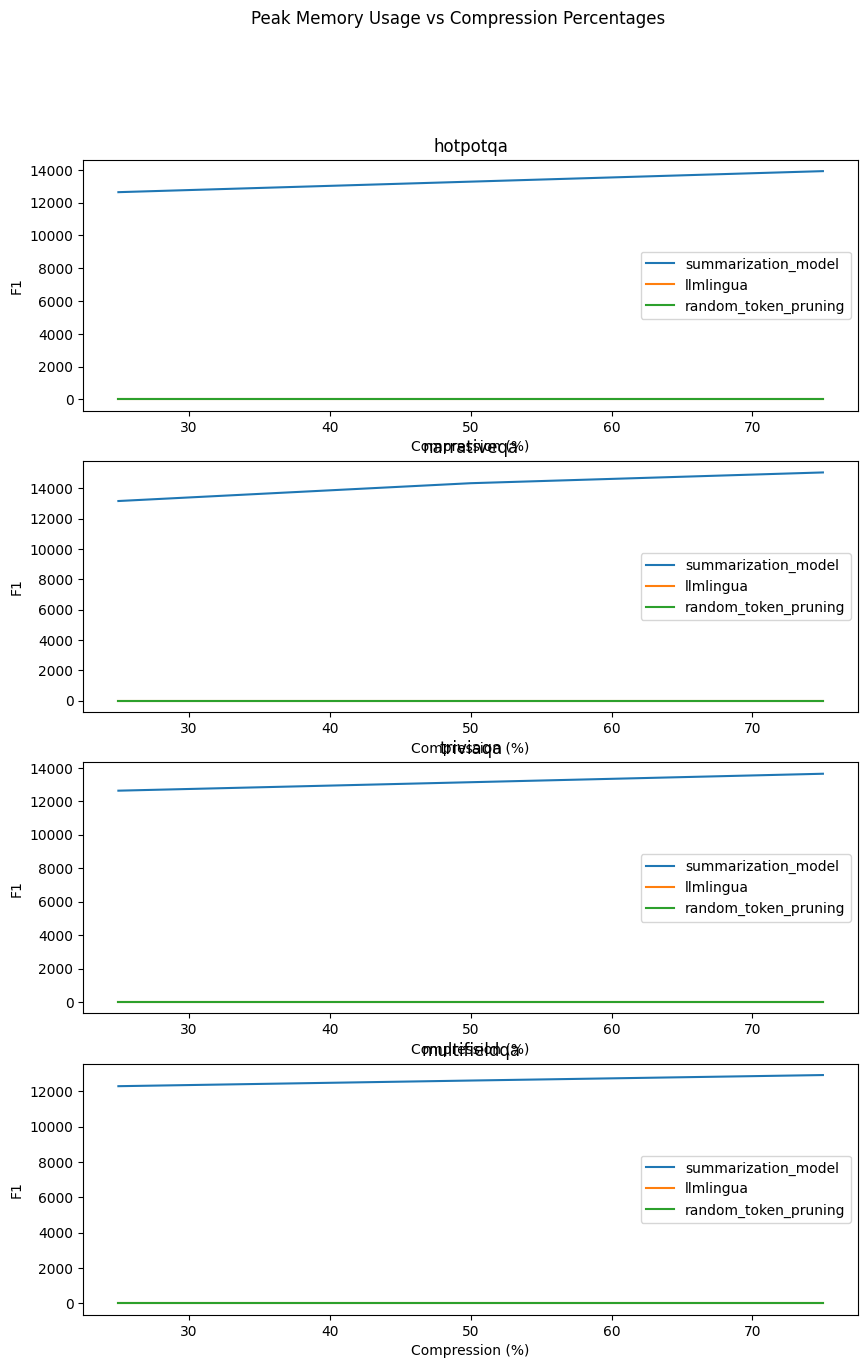

In [53]:
fig, axes = plt.subplots(4, figsize=(10, 15))
fig.suptitle('Peak Memory Usage vs Compression Percentages')

for i, dataset_name in enumerate(dataset_name_list):
    axes[i].plot(all_bart_metric[dataset_name]['Compression (%)'], all_bart_metric[dataset_name]['Peak Memory (MB)'], label='summarization_model')
    axes[i].plot(llmlingua_metrics[dataset_name]['Compression (%)'], llmlingua_metrics[dataset_name]['Peak Memory (MB)'], label='llmlingua')
    axes[i].plot(random_token_pruning_metrics[dataset_name]['Compression (%)'], random_token_pruning_metrics[dataset_name]['Peak Memory (MB)'], label='random_token_pruning')
    axes[i].set_title(dataset_name)
    axes[i].legend()
    axes[i].set_xlabel('Compression (%)')
    axes[i].set_ylabel('F1')

plt.show()